# Text Detection in Images with EAST Detector

- east detector: https://arxiv.org/pdf/1704.03155v2.pdf

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [57]:
def display_img(img, axis=False, grayscale=False):
    if grayscale:
        if len(img.shape) == 3:  # Check if the image is RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert BGR to grayscale
        cmap = 'gray'
    else:
        if len(img.shape) == 2:  # Check if the image is grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
        cmap = None

    plt.imshow(img, cmap=cmap)
    if not axis:
        plt.axis('off')
    plt.show()

In [58]:
detector = 'frozen_east_text_detection.pb'
height, width = 320, 320

In [59]:
img_path = 'Imagens/caneca.jpg'
min_conf = 0.9

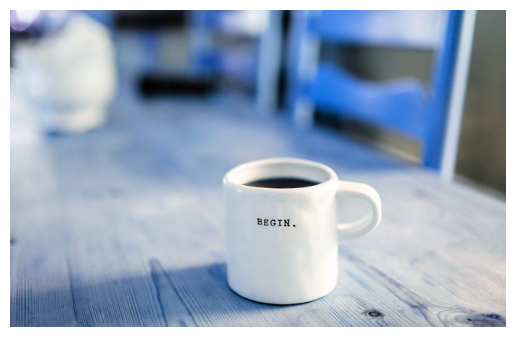

In [60]:
img = cv2.imread(img_path)
display_img(img)

In [61]:
H =  img.shape[0]
W = img.shape[1]
width_ratio = W / float(320)
height_ratio = H / float(320)
print(H, W)

480 750


In [62]:
original = img.copy()

In [63]:
img = cv2.resize(img, (width, height))
H = img.shape[0]
W = img.shape[1]
print(H, W)

320 320


In [64]:
original.shape

(480, 750, 3)

In [65]:
img.shape

(320, 320, 3)

In [66]:
# Define the TWO output layer names ofr the EAST detector model
# FIRST LAYER : output probabilities of a region containing text or not.
# SECOND LAYER: bounding box coordinates of text.

layerNames = [
    "feature_fusion/Conv_7/Sigmoid", 
    "feature_fusion/concat_3"
]

In [67]:
neural_net = cv2.dnn.readNet(detector)
blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), swapRB=True, crop=False)

In [68]:
neural_net.setInput(blob)
scores, geometry = neural_net.forward(layerNames)

In [84]:
scores[0, 0, 0]

array([1.4775183e-07, 5.3355325e-07, 6.1831190e-07, 5.4498480e-07,
       6.8389460e-07, 6.3538363e-07, 2.8739106e-07, 1.1796508e-07,
       1.4145149e-07, 1.9870522e-07, 1.9250447e-07, 1.7849250e-07,
       3.2116756e-07, 1.1000186e-06, 1.8538535e-06, 7.2049903e-07,
       2.2694773e-07, 1.9305345e-07, 2.7782812e-07, 4.6434533e-07,
       5.4333816e-07, 6.3162935e-07, 6.5712828e-07, 6.7843467e-07,
       6.9376136e-07, 5.5208506e-07, 4.2479184e-07, 3.1016791e-07,
       4.7803371e-07, 4.5292870e-07, 5.1470943e-07, 5.0100130e-07,
       3.5401621e-07, 4.9244062e-07, 2.2611391e-06, 3.2066059e-06,
       2.2184138e-06, 1.9173272e-06, 1.9552849e-06, 2.5295287e-06,
       3.1743598e-06, 2.3743835e-06, 3.7373130e-07, 5.9925412e-08,
       7.6657173e-08, 1.3193031e-07, 1.9002201e-07, 3.2695496e-07,
       1.9928707e-07, 1.4942634e-07, 2.1175209e-07, 2.1544535e-07,
       2.3616482e-07, 3.0993047e-07, 3.7835929e-07, 4.7277859e-07,
       6.3466234e-07, 8.9479857e-07, 1.0728420e-06, 9.4951156e

In [83]:
scores[0, 0, 0][1]

5.3355325e-07

# Decode geometry

In [70]:
def geometric_data(geometry, index):
    x_data_0 = geometry[0, 0, index]
    x_data_1 = geometry[0, 1, index]
    x_data_2 = geometry[0, 2, index]
    x_data_3 = geometry[0, 3, index]
    angle_data = geometry[0, 4, index]
    
    return angle_data, x_data_0, x_data_1, x_data_2, x_data_3

In [71]:
def geometry_calculations(angle_data, x_data_0, x_data_1, x_data_2, x_data_3, x, y):
    offset_x = x * 4.0
    offset_y = y * 4.0
    angle = angle_data[x]
    cosine = np.cos(angle)
    sine = np.sin(angle)
    height = x_data_0[x] + x_data_2[x]
    width = x_data_1[x] + x_data_3[x]
    
    end_x = int(offset_x + (cosine * x_data_1[x]) + (sine * x_data_2[x]))
    end_y = int(offset_y - (sine * x_data_1[x]) + (cosine * x_data_2[x]))
    
    start_x = int(end_x - width)
    start_y = int(end_y - height)
    
    return start_x, start_y, end_x, end_y

In [72]:
scores.shape[2:4]

(80, 80)

In [73]:
rows, columns = scores.shape[2:4]
min_confidence = 0.9
confidences = []
boxes = []

In [74]:
for index in range(0, rows):
    # print(index)
    score_data = scores[0, 0, index]
    
    angle_data, x_data_0, x_data_1, x_data_2, x_data_3 = geometric_data(geometry, index)
    
    for column in range(0, columns):
        if score_data[column] < min_confidence:
            continue
        
        start_x, start_y, end_x, end_y = geometry_calculations(angle_data, x_data_0, x_data_1, x_data_2, x_data_3, column, index)
        confidences.append(score_data[column])
        boxes.append((start_x, start_y, end_x, end_y))

In [75]:
detections = non_max_suppression(np.array(boxes), probs=confidences)
copy = original.copy()

In [76]:
img.shape

(320, 320, 3)

In [77]:
original.shape

(480, 750, 3)

In [78]:
width_ratio, height_ratio

(2.34375, 1.5)

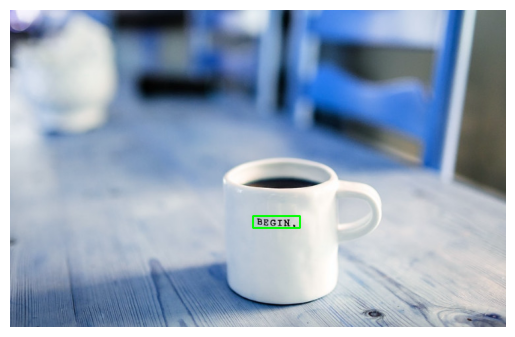

In [79]:
for (start_x, start_y, end_x, end_y) in detections:
    # print(start_x, start_y, end_x, end_y)
    start_x = int(start_x * width_ratio)
    start_y = int(start_y * height_ratio)
    end_x = int(end_x * width_ratio)
    end_y = int(end_y * height_ratio)
    roi = copy[start_y:end_y, start_x:end_x]
    
    cv2.rectangle(original, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

display_img(original)